In [15]:
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt

from util.path import Path
from constants import CONVS_STRANGERS

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


# num of turns per convo

In [7]:
def reduce_consecutive(df: pd.DataFrame, on: str) -> pd.DataFrame:
    newdf = df.copy()
    newdf['key'] = (df[on] != df[on].shift(1)).astype(int).cumsum()
    newdf = newdf.groupby('key').first()  # NOTE hardcoded function
    newdf.reset_index(drop=True, inplace=True)
    return newdf

In [27]:
transpath = Path(root="stimuli", datatype="transcript", suffix="utterance", ext=".csv")
files = glob(transpath.starstr(["conv", "datatype"]))
print(len(files))

dfs = []
for filename in files:
    filepath = Path.frompath(filename)
    if filepath['conv'] in CONVS_STRANGERS:
        df = pd.read_csv(filename)
        df.insert(0, "trial", filepath["trial"])
        df.insert(0, "run", filepath["run"])
        df.insert(0, "conv", filepath["conv"])
        dfs.append(df)
df = pd.concat(dfs)
df.sort_values(["conv", "run", "trial", "onset"], inplace=True)
df.reset_index(drop=True, inplace=True)

df['textlen'] = df.text.apply(len)

print(len(df))
df.head()

590
1816


,conv,run,trial,speaker,onset,text
0,104,1,1,4,3,"Um, I would not want to be famous in any capac..."
1,104,1,1,104,26,"Yeah, I think it's kind of bizarre, uh, in lik..."
2,104,1,1,4,55,I agree. I think that you also give up a lot o...
3,104,1,1,104,83,"Yeah, when you look at the examples like, Prin..."
4,104,1,1,4,117,"Um...actually couldn't hear you that well, but..."


In [43]:
dfl = df.groupby(['conv', 'run', 'trial']).textlen.sum()
dfl

conv  run  trial
104   1    1        2215
           4        2607
      2    6        2435
           7        2631
      3    10       2540
                    ... 
174   3    12       2465
      4    13       2678
           15       2456
      5    18       2583
           20       2554
Name: textlen, Length: 290, dtype: int64

In [55]:
df2 = reduce_consecutive(df, on='speaker')
dfc = df2.groupby(['conv', 'run', 'trial']).speaker.count()
dfc

conv  run  trial
104   1    1        6
           4        4
      2    6        9
           7        6
      3    10       6
                   ..
174   3    12       2
      4    13       2
           15       2
      5    18       2
           20       2
Name: speaker, Length: 290, dtype: int64

In [62]:
df2.groupby(['conv', 'run', 'trial']).onset.count()

conv  run  trial
104   1    1        6
           4        4
      2    6        9
           7        6
      3    10       6
                   ..
174   3    12       2
      4    13       2
           15       2
      5    18       2
           20       2
Name: onset, Length: 290, dtype: int64

In [57]:
df2.onset.diff()

0        NaN
1       23.0
2       29.0
3       28.0
4       34.0
        ... 
1408    59.0
1409   -57.0
1410    88.0
1411   -72.0
1412    92.0
Name: onset, Length: 1413, dtype: float64

In [48]:
df2 = pd.concat((dfl, dfc), axis=1)
df2

textlen  speaker
conv run trial                  
104  1   1         2215        6
         4         2607        4
     2   6         2435        9
         7         2631        6
     3   10        2540        6
...                 ...      ...
174  3   12        2465        2
     4   13        2678        2
         15        2456        2
     5   18        2583        2
         20        2554        2

[290 rows x 2 columns]

<Axes: xlabel='speaker', ylabel='textlen'>

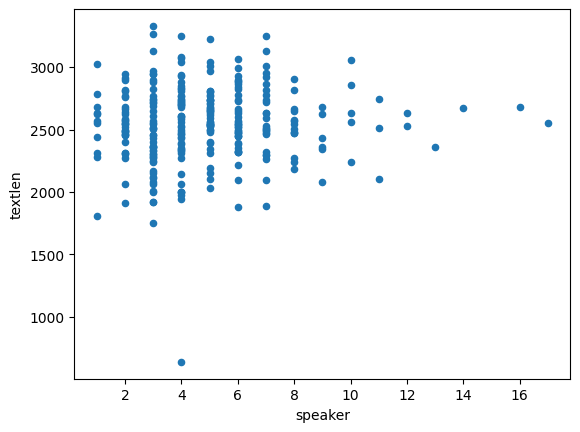

In [54]:
df2.plot.scatter('speaker', 'textlen')

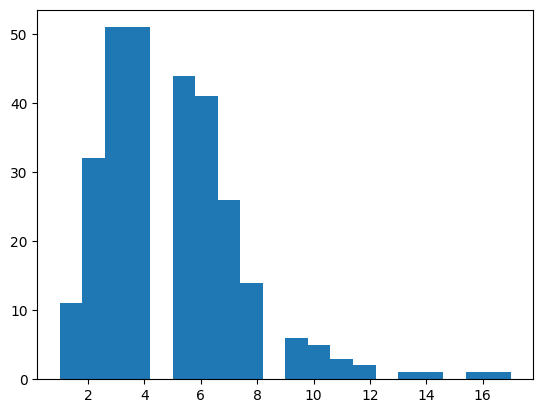

In [30]:
plt.hist(df2.groupby(['conv', 'run', 'trial']).speaker.count().values, bins=20);

# surprising utterances

do these relate to enjoyment more?